# Objective Function

In [1]:
import numpy as np
from typing import Tuple
def evalfunc(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> float:
    """
    Task 1: the objective function
    (Remember to vectorize as much as possible)


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective value.
    """
    # compute mean returns first. ret_mu shape should be (3,)
    ret_mu = ret.mean(axis=0)

    # first part
    drift = -ret_mu.dot(portfolio)

    # second part
    # weighed deviation from mean (part within []^pi)
    deviation = (ret - ret_mu).dot(portfolio)
    risk = theta * (
        (np.abs(deviation)**pi).mean()
    )**(1/pi)
    return drift + risk

# Gradient

Following matrix notations, the objective function can be rewritten as
\begin{align*}
	\text{minimize} \ -\bar{\textbf{r}}'\textbf{x}
	+
	\frac{\theta}{T^{1/\pi}}
		||
			(\textbf{r} - \bar{\textbf{r}})'\textbf{x}
		||_{\pi}
\end{align*}
where $||\cdot||^\pi$ is the $L^\pi$ norm. Here we must investigate how to take the derivative of a $L^p$ norm with respect to the function argument. According to
[Wikipedia - Norm](https://en.wikipedia.org/wiki/Norm_(mathematics)),

\begin{align*}
\frac{\partial ||\textbf{x}||_p}{\partial \textbf{x}}&=\frac{\textbf{x}\circ |\textbf{x}|^{p-2}}{||\textbf{x}||_p^{p-1}}
\end{align*}
where $\circ$ is element-wise matrix multiplication, and $|\textbf{x}| = (|x_1|, \ldots, |x_n|)$ is the element-wise absolute value. In other words, 
\begin{align*}
\textbf{x}\circ |\textbf{x}|^{p-2}&=[x_1,\ldots, x_n]\circ [|x_1|^{p-2},\ldots, |x_n|^{p-2}]\\
&=[(x_1\cdot |x_1|^{p-2}),\ldots, (x_n\cdot |x_n|^{p-2})]
\end{align*}
Therefore, if we were to take derivative of the objective function with respect to $\textbf{x}$ can be obtained via chain rule:
\begin{align*}
\frac{\partial \text{obj}}{\partial \textbf{x}}
&=-\bar{\textbf{r}} + \frac{\theta}{T^{1/\pi}}\cdot  \frac{[(\textbf{r} - \bar{\textbf{r}})'\textbf{x}]\circ |(\textbf{r} - \bar{\textbf{r}})'\textbf{x}|^{\pi -2}}{||(\textbf{r} - \bar{\textbf{r}})'\textbf{x}||_\pi^{\pi-1}}\cdot (\textbf{r}-\bar{\textbf{r}})
\end{align*}

In [2]:
def evalgrad(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> np.ndarray:
    """
    Task 1: the objective function gradient


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective gradient vector
    """
    T = ret.shape[0]
    ret_mu = ret.mean(axis=0)
    delta = ret - ret_mu
    dev = delta.dot(portfolio)
    nom = dev * np.absolute(dev)**(pi-2)
    # p-norm involves abs
    denom = ((np.absolute(dev)**pi).sum())**(1-1/pi)
    return -ret_mu + (
        (theta / T**(1/pi))*nom/denom
    ).dot(delta)


# Main Algorithm: Gradient Descent

In [3]:
def backtrack(
        x:np.ndarray, ret:np.ndarray, 
        pi:float , theta:float, fval:float, grad:np.ndarray, delta:np.ndarray,
        alpha:float = 0.5, beta:float = 0.75, step_eps:float=1e-4,
        init_step:float = 1
    ) -> Tuple[float, bool]:
    """
    Task 1: backtrack step finder


    Parameters
    --------------
    x: np.ndarray: portfolio weights

    ret: np.ndarray: return matrix

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective

    fval: float: current functional value

    grad: np.ndarray: gradient

    delta: np.ndarray: direction vector

    alpha: float: acceptance threshold

    beta: float: shrink ratio

    step_eps: float: the tolerance lower bound of backtrack step

    init_step: float: intial step size


    Returns
    --------------
    Tuple[float, bool]: optimal step size, success boolean
    """
    grad_dot_delta = grad.dot(delta)
    step = init_step
    goon = True
    success = False
    
    while goon:
        fnew = evalfunc(x + step * delta, ret, pi, theta)
        target = alpha * step * grad_dot_delta

        if fnew - fval <= target:
            goon = False
            success = True
        else:
            step *= beta
        if step < step_eps:
            goon = False
    return step, success

def get_descent(
    step: float, 
    grad: np.ndarray,
    momentum: bool = False,
    olddelta: np.ndarray = None,
    mu: float = None
) -> np.ndarray:
    """
    Task 1: helper function to generate the descent step,
    for both momentum and non-momentum case.


    Parameters
    --------------
    step: float: step size

    grad: np.ndarray: gradient

    momentum: bool: momentum flag

    olddelta: np.ndarray: moving average vector for momentum

    mu: float: conservation parameter for momentum descent

    Returns
    --------------
    np.ndarray: descent step
    """
    if not momentum:
        # if not momentum just negative gradient direction times step size
        return - step * grad
    else:
        # if momentum the convex combination of moving average and conventional step
        assert (olddelta is not None) and (mu is not None)
        return - step * grad + (1-mu) * olddelta



def run_grad_desc(
    x: np.ndarray,
    ret: np.ndarray,
    pi: float, 
    theta: float,
    x_history: np.ndarray,
    f_history: np.ndarray,
    bt: bool = True,
    bt_a: float = None,
    bt_b: float = None,
    bt_init_step: float = 1,
    momentum: bool = False,
    mom_mu: float = None,
    max_iter: int = 1000,
    step_eps: float = 0.05,
) -> Tuple[bool, np.ndarray]:
    """
    Task 1: Main GD algorithm. Incorporates the possibility to toggle
    both the momentum flag and the backtrack flag.


    Parameters
    --------------
    x: np.ndarray: portfolio weights

    ret: np.ndarray: return matrix

    pi: float: the exponent parameter of the objective

    theta: float: the risk-aversion parameter of the objective

    x_history: np.ndarray: portfolio weight vector

    f_history: np.ndarray: objective vector

    bt: bool: backtrack flag. If False, use constant step specified by step_eps.

    bt_a: float: backtrack acceptance threshold

    bt_b: float: backtrack shrink ratio

    bt_init_step: float: backtrack initial step size, default 1.

    momentum: bool: momentum flag

    mom_mu: float: momentum conservation parameter

    max_iter: int: iteration limit

    step_eps: float: the tolerance lower bound of backtrack step if bt=True,
    the step size if bt=False.
    """
    converged = False
    iter = 0
    descent = np.zeros_like(x)
    while iter < max_iter:
        x_history[iter] = x
        fval = evalfunc(x, ret, pi, theta)
        grad = evalgrad(x, ret, pi, theta)
        f_history[iter] = fval  
        if bt:
            # if backtrack, call backtrack function to compute step size
            step, goodstep = backtrack(x, ret, pi, theta, fval, grad, -grad, bt_a, bt_b, step_eps, bt_init_step)
            goodstep = True
        else:
            # if not, use constant step size
            goodstep = True
            step = step_eps

        # one line to compute descent for both momentum and non-momentum case
        descent = get_descent(step, grad, momentum, descent, mom_mu)
        if goodstep:
            # if good step, descend
            x += descent
            
            if np.isclose(grad, 0).all():
                converged = True
                print("Converged. x:", x)
                break
            else:
                pass
                # if iter % 10 == 0:
                #     print(f"grad {iter} = {grad}")
                #     print(f"grad L2 {iter} = {np.inner(grad, grad)}")
        iter += 1
    return iter, converged

# Data processing

In [4]:
import pandas as pd
import datetime

def is_open_or_noon(dt: datetime.datetime) -> bool:
    """Task 1: read helper function for datetime parsing"""
    t = dt.time()
    return t == datetime.time(9,30) or t == datetime.time(12,0)

def is_open(dt:datetime.datetime) -> bool:
    """Task 1: read helper function for datetime parsing"""
    return dt.time() == datetime.time(9,30)

def my_dt_parser(s: str) -> datetime.datetime:
    """Task 1: custom datetime parser. 5x faster than pd.to_datetime"""
    date, time = s.split()
    m, d, y = date.split("/")
    H, M = time.split(":")
    return datetime.datetime(
        year = 2000 + int(y),
        month = int(m),
        day = int(d),
        hour = int(H),
        minute = int(M)
    )

def read_asset(asset:str, data_dir: str="../data/") -> pd.DataFrame:
    """
    Task 1: reads a single asset.


    Parameters
    --------------
    asset: str: asset name

    data_dir: str: local data directory


    Returns
    --------------
    pd.DataFrame: pandas dataframe containing asset returns and price
    """
    # static var to mark missing data
    missing = -999.
    # read csv
    csv_path = data_dir + asset + ".csv"
    df = pd.read_csv(csv_path, low_memory=False, header=3).loc[:, ["Dates", "Close"]]
    # read up to empty entries
    df = df.iloc[:df["Close"].isna().argmax()]

    # deal with first row missing date
    df.loc[0,"Dates"] = df.loc[1,"Dates"].replace("31", "30")

    # extract open or noon data
    df["dt"] = df["Dates"].apply(my_dt_parser)
    df["Date"] = df["dt"].apply(lambda dt: dt.date())
    open_or_noon = df["dt"].apply(is_open_or_noon)
    df = df.loc[open_or_noon]

    # compute daily return
    ret = df.loc[:, ["Close","Date"]].groupby("Date").apply(
        lambda x: x["Close"].iloc[1]/x["Close"].iloc[0]-1 if len(x) == 2 else missing
    ).values

    ret = ret[~np.isnan(ret)]

    # return along with daily open price
    df = df.loc[df["dt"].apply(is_open)]
    df["ret"] = ret

    # filter out bad dates with missing data (particularly at noon)
    df = df.loc[df.ret > missing + 1]
    df.set_index("Date", inplace=True)
    df = df[["ret", "Close"]]
    df.rename(columns = {"ret": f"{asset}_ret", "Close": f"{asset}_price"}, inplace = True)
    return df

read_asset("AMZN")

,AMZN_ret,AMZN_price
Date,,
2021-01-04,-0.027139,3262.80
2021-01-05,0.006993,3174.80
2021-01-06,0.010673,3146.17
2021-01-07,0.010303,3162.20
2021-01-08,-0.005051,3173.77
...,...,...
2021-07-07,-0.004655,3729.24
2021-07-08,0.004955,3652.90
2021-07-09,0.002678,3718.54


In [5]:
def read_all(data_dir: str = "../data/", T: int = 100) -> Tuple[pd.DataFrame,pd.DataFrame]:
    """
    Task 1.5: reads all asset returns and sever into train and test.


    Parameters
    --------------
    data_dir: str: local data directory

    T: int: size of the traning period.


    Returns
    --------------
    Tuple[pd.DataFrame, pd.DataFrame]: train and test pandas dataframe containing returns and prices
    """
    assets = ["AMZN", "NFLX", "TSLA"]

    dfs = [read_asset(asset, data_dir) for asset in assets]

    df = dfs[0]
    for i in range(1, 3):
        df = df.join(dfs[i])
    df = df.dropna()
    return df.iloc[:T], df.iloc[T:]

train, test = read_all()

# Benchmarking

In [6]:
# split
ret_train = train.loc[:,[col for col in train.columns if "ret" in col]]
price_train = train.loc[:,[col for col in train.columns if "price" in col]]
ret_test = test.loc[:,[col for col in test.columns if "ret" in col]].values
price_test= test.loc[:,[col for col in test.columns if "price" in col]].values

# Task 2
def benchmark(ret_test: np.ndarray, price_test: np.ndarray, x: np.ndarray):
    """Task 2: Benchmarking
    
    
    Parameters
    --------------
    ret_test: np.ndarray: test return matrix

    price_test: np.ndarray: test price matrix

    x: np.ndarray: portfolio weights
    """
    p0 = 1e9
    shares = p0 / np.abs(x).sum() * x / price_test
    portfolio_return = ret_test.dot(x).mean()
    return shares, portfolio_return


# Example Run

$\pi = 2$, $\theta = 10^{-6}$ for $10000$ iterations. 

Expected behavior: since almost no risk aversion is factored into the objective, the objective and weights should diverge to negative infinity since all three assets have negative mean returns in training data.


In [7]:
ret = ret_train.values
pi = 2; theta = 1e-6; portfolio = np.array([1e-3]*3)
max_iter = 10000
m = len(portfolio)
x_history = np.zeros((max_iter, m))
f_history = np.zeros(max_iter)
it, converged = run_grad_desc(
    x = portfolio, 
    ret = ret, 
    pi = pi, theta = theta, x_history = x_history, f_history = f_history,
    bt=True, bt_a=0.5, bt_b=0.75, bt_init_step=1,
    momentum=False, mom_mu=0.8, 
    max_iter = max_iter, step_eps=1e-4, 
)

print(f"Converged: {str(converged)}, after {it} iterations")

Converged: False, after 10000 iterations


# Visualization

Final objective = -0.03885
Final portfolio = [-2.57826, -3.4718, -19.22731]


Text(0.5, 1.0, 'Pi = 2, Theta = 1e-06,\nFinal portfolio = [-2.57826, -3.4718, -19.22731]')

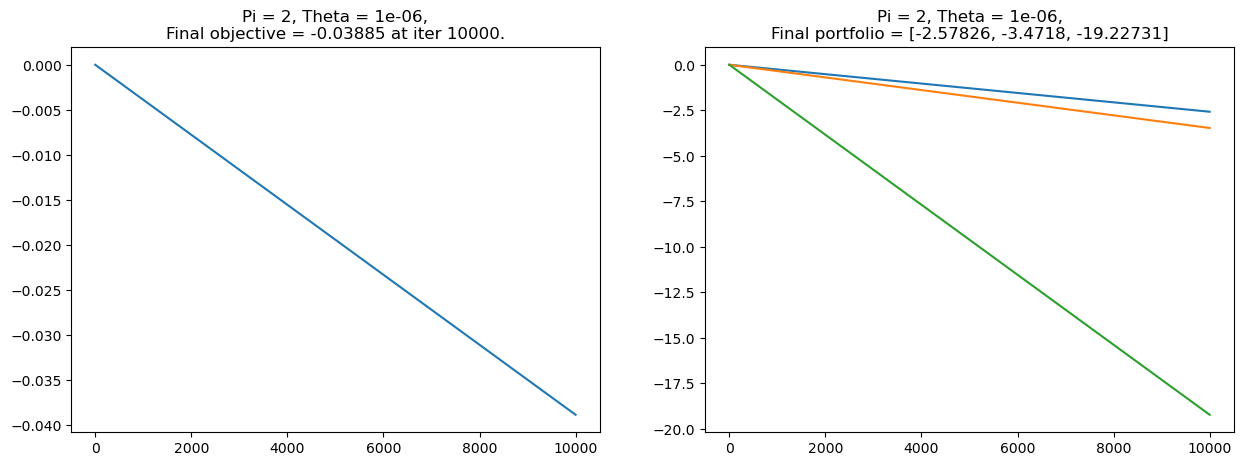

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize= (15, 5))

ax[0].plot(f_history[:it])
ax[1].plot(x_history[:it])

final_objective = round(f_history[it-1],5)
final_portfolio = [round(p,5) for p in x_history[it-1]]
print(f"Final objective = {final_objective}")
print(f"Final portfolio = {final_portfolio}")

ax[0].set_title(f"Pi = {pi}, Theta = {theta},\nFinal objective = {final_objective} at iter {it}.")
ax[1].set_title(f"Pi = {pi}, Theta = {theta},\nFinal portfolio = {final_portfolio}")

# Validation

In [9]:
shares, ret_bar = benchmark(ret_test, price_test, np.array(final_portfolio))
print("Shares to be traded for each day (AMZN, NFLX, TSLA respectively):")
print(shares)
print()
print("Final mean portfolio returns:")
print(ret_bar)

Shares to be traded for each day (AMZN, NFLX, TSLA respectively):
[[  -29824.28145445  -259049.69775212 -1131907.42090212]
 [  -29656.83259134  -258338.31724819 -1110523.55050797]
 [  -29608.19295821  -257727.51960552 -1114591.70037429]
 [  -29647.00571188  -260890.00066135 -1110935.51871259]
 [  -29562.11143644  -255655.10711819 -1116866.5109101 ]
 [  -28735.03557593  -257471.45889619 -1112423.74143794]
 [  -27351.080738    -253171.64614141 -1147947.70142832]
 [  -27922.67632057  -258299.45038585 -1210959.1730526 ]
 [  -27429.78274575  -258976.43018417 -1159196.43079052]
 [  -27227.18276108  -255142.20119664 -1145729.27960927]
 [  -27501.67016231  -255774.12940311 -1104892.22158534]]

Final mean portfolio returns:
0.0026382216821722706


In [10]:
# setup looping

result = []

thetas = [10**i for i in [-1, 1, 3, 5, 6]]
pis = [0.5, 2, 4, 6]
bts = [True, False]
moms = [True, False]
portfolio = np.array([1e-3]*3)

max_iter = 20000
m = len(portfolio)
ret = ret_train.values


loud = True

for theta in thetas:
    for pi in pis:
          for bt in bts:
                for mom in moms:
                    if loud:
                        print("*"*60)
                        print(f"RUNNING: theta={theta}, pi={pi}, bt={bt}, mom={mom}...")
                    
                    if bt:
                        step_epss = [1e-4]
                    else:
                        step_epss = [0.1, 0.01, 1]
                        step_epss
                    for step_eps in step_epss:
                        if loud:
                            print("\tstep_eps:", step_eps)
                        x_history = np.zeros((max_iter, m))
                        f_history = np.zeros(max_iter)
                        it, converged = run_grad_desc(
                            x = portfolio, 
                            ret = ret, 
                            pi = pi, theta = theta, x_history = x_history, f_history = f_history,
                            bt=bt, bt_a=0.5, bt_b=0.75, momentum=mom, mom_mu=0.8, 
                            max_iter = max_iter, step_eps=step_eps, 
                        )
                        # portfolio_history = np.hstack([x_history, (1 - x_history.sum(axis = 1)).reshape(-1, 1)])
                        final_objective = f_history[it-1]
                        final_portfolio = x_history[it-1]
                        result.append(
                            {
                                "theta": theta,
                                "pi": pi,
                                "backtrack": bt,
                                "momentum": mom,
                                "step_size/step_eps": step_eps,
                                "converged": converged,
                                "converged_iter": it,
                                "final_objective": final_objective,
                                "final_portfolio": final_portfolio
                            }
                        )
                        if loud:
                            print("*"*60)
                            print()


result_df = pd.DataFrame(result)



************************************************************
RUNNING: theta=0.1, pi=0.5, bt=True, mom=True...
	step_eps: 0.0001
************************************************************

************************************************************
RUNNING: theta=0.1, pi=0.5, bt=True, mom=False...
	step_eps: 0.0001
************************************************************

************************************************************
RUNNING: theta=0.1, pi=0.5, bt=False, mom=True...
	step_eps: 0.1
************************************************************

	step_eps: 0.01
************************************************************

	step_eps: 1
************************************************************

************************************************************
RUNNING: theta=0.1, pi=0.5, bt=False, mom=False...
	step_eps: 0.1
************************************************************

	step_eps: 0.01
************************************************************

	step_eps: 

************************************************************

	step_eps: 0.01
************************************************************

	step_eps: 1
************************************************************

************************************************************
RUNNING: theta=1000, pi=0.5, bt=True, mom=True...
	step_eps: 0.0001
************************************************************

************************************************************
RUNNING: theta=1000, pi=0.5, bt=True, mom=False...
	step_eps: 0.0001
************************************************************

************************************************************
RUNNING: theta=1000, pi=0.5, bt=False, mom=True...
	step_eps: 0.1
************************************************************

	step_eps: 0.01
************************************************************

	step_eps: 1
************************************************************

************************************************************

************************************************************

	step_eps: 1
************************************************************

************************************************************
RUNNING: theta=100000, pi=6, bt=False, mom=False...
	step_eps: 0.1
************************************************************

	step_eps: 0.01
************************************************************

	step_eps: 1
************************************************************

************************************************************
RUNNING: theta=1000000, pi=0.5, bt=True, mom=True...
	step_eps: 0.0001
************************************************************

************************************************************
RUNNING: theta=1000000, pi=0.5, bt=True, mom=False...
	step_eps: 0.0001
************************************************************

************************************************************
RUNNING: theta=1000000, pi=0.5, bt=False, mom=True...
	step_eps: 0.1
*

# Model selection for each ($\pi$, $\theta$) pair:

In [11]:
result_df["portfolio_return"] = result_df.final_portfolio.apply(
    lambda x : benchmark(ret_test, price_test, x)[1]
)

groupby_best = result_df.loc[
    :,
    ["theta", "pi", "final_objective"]
].groupby(["theta", "pi"]).idxmin().values.flatten()

groupby_best = result_df.iloc[groupby_best]

groupby_best

,theta,pi,backtrack,momentum,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio,portfolio_return
7,0.1,0.5,False,False,1.0000,False,20000,-1.027480e-02,"[1.9451100184162662, -1.8387475938041844, -22....",1.887680e-02
15,0.1,2.0,False,False,1.0000,False,20000,1.359354e-06,"[-0.00022872524583872366, -0.00049311814851639...",1.104990e-06
16,0.1,4.0,True,True,0.0001,False,20000,1.810459e-10,"[1.2061418041729876e-07, -2.014131177213361e-0...",3.100682e-10
25,0.1,6.0,True,False,0.0001,False,20000,9.022406e-11,"[5.460932766078292e-08, 2.924154795558308e-09,...",1.546106e-10
33,10.0,0.5,True,False,0.0001,False,20000,7.362724e-07,"[5.4882770017230954e-06, -1.0800253493009756e-...",1.178867e-08
41,10.0,2.0,True,False,0.0001,False,20000,6.792999e-07,"[6.81057067414739e-07, 6.563324740769511e-07, ...",7.231140e-10
48,10.0,4.0,True,True,0.0001,False,20000,4.343631e-06,"[-2.902757954119548e-06, -2.2008781207153873e-...",-1.928422e-09
57,10.0,6.0,True,False,0.0001,False,20000,1.042315e-06,"[7.237871897330365e-07, 3.337930614255521e-07,...",8.410645e-10
64,1000.0,0.5,True,True,0.0001,False,20000,9.724120e-03,"[-5.0190242051786525e-05, -2.7117242624416548e...",-5.948793e-07
73,1000.0,2.0,True,False,0.0001,False,20000,3.574132e-03,"[3.3928779293716815e-05, 3.469359888752315e-05...",3.179858e-08


# Summary analytics

In [13]:
share_bt = groupby_best.backtrack.mean()
share_mom = groupby_best.momentum.mean()

most_common_constant_stepsize = groupby_best[groupby_best.backtrack == False]["step_size/step_eps"].mode().values[0]


print(f"{round(share_bt*100, 2)}% of best models used backtrack.")
print()
print(f"{round(share_mom*100, 2)}% of best models used momentum.")
print()
print(f"For best constant step size models, the most common step size is {most_common_constant_stepsize}.")

90.0% of best models used backtrack.

65.0% of best models used momentum.

For best constant step size models, the most common step size is 1.0.
